# Conrtrolled intersection simulation 

## 0. Setup code 
In this section, we will setup all the required libraries and parameters for future usage. 

In [1]:
import numpy as np 
%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib import ticker 
from matplotlib.ticker import PercentFormatter 
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
plt.rcParams.update(params)

## 1. Initialize Variables 
Intialize required variables, parameters and class `Car` 

In [2]:
def avg(l): 
    return float(sum(l)) / len(l) if len(l) != 0 else 0 
def kph2mps(speed): 
    return float(speed) * 1000.0 / 3600.0 
def get_acceleration(speed, time): 
    return speed / time 
def isEmpty(queue): 
    return len(queue) == 0 

In [3]:
speed = kph2mps(60) 
acceleration = get_acceleration(speed, 5) 
dt = 0.1 
queues = [[], [], [], []] 
def auto_poly(): 
    x = np.array([40, 50, 60, 70, 80, 90, 100, 110]) 
    y = np.array([9, 14, 20, 27, 36, 45, 56, 67]) 
    x = x * 1000.0 / 3600.0 
    y = y + 2.5 
    return np.polyfit(x, y, 2) 

def manual_poly(): 
    x = np.array([40, 50, 60, 70, 80, 90, 100, 110]) 
    y = np.array([26, 35, 45, 56, 69, 83, 98, 113]) 
    x = x * 1000.0 / 3600.0 
    y = y + 2.5 
    return np.polyfit(x, y, 2) 

def safe_auto(speed, poly): 
    return np.polyval(poly, speed)

def safe_manual(speed, poly): 
    return np.polyval(poly, speed)

auto_polynomial = auto_poly() 
manual_polynomial = manual_poly() 
autoAllow = (acceleration * (safe_auto(kph2mps(60), auto_polynomial) / speed) ** 2) / 2 + 4.4 
manualAllow = (acceleration * (safe_manual(kph2mps(60), manual_polynomial) / speed) ** 2) / 2 + 4.4 

In [4]:
speed = kph2mps(60) 
acceleration = get_acceleration(speed, 5) 
dt = 0.1 

class Car: 
    def __init__(self, index, carType, direction): 
        self.id = index 
        self.pos = 0 
        self.speed = 0 
        self.comf = np.random.normal(speed, speed * std * carType) 
        self.acc = np.random.normal(acceleration, acceleration * std * carType) 
        self.length = 4.4 
        self.type = carType # 0 for auto, 1 for manual 
        self.direction = direction # 0 for turn, 1 for straight 
        self.require = distance - (self.comf ** 2 - kph2mps(30) ** 2) / (2 * self.acc) - 2 
        self.slow = -1 # -1 for default, 0 for no need to slow, 1 for need to slow 

## 2. Left lane simulation 
In our simulation, there would be four lanes with traffic, which include two left lanes and two right lanes. Cars in the left lane may turn left or go straight, while cars in the right lane may turn right and also go straight. For simplicity, the traffic lights would never change its sign, as we are not interested in the duration of light changing due to its high variance. 

This section provides the functions for left lane traffic, as cars would be added to the queue with a certain probability after the car in front has passed a certain amount of distance. Cars would follow similar rules to the single lane traffic, while all cars would be required to reduce their speed to `30` kph (or `8.33` mps) when turning left. To guarentee sufficient space, cars that turn right would start applying break roughly `55` meters (depending on the car's comfortable speed) before the intersection. 

At about `13` meters before the intersection, the car would pass the intersection at `30` kph if there are no traffic on the other side of the traffic and no pedestrians crossing. Otherwise, it would slow down at the median and wait until the conditions suffice. When the crossing is initiated, a signal would be sent to pedestrians to prevent them from crossing. The signal would continue for `4` seconds if the car stopped in the median, `3` otherwise. 

In [5]:
def checkFirst(queue, car, start, time): 
    threshold = autoAllow if car.type == 0 else manualAllow 
    if (isEmpty(queue) or queue[0].pos > threshold) and np.random.uniform() < carDensity / 60 * dt: 
        start[car.id] = time 
        queue.insert(0, car) 
        return True 
    return False 

In [6]:
def addCar(queue, start, time): 
    global car, index 
    if checkFirst(queue, car, start, time): 
        index += 1 
        auto = 0 if np.random.uniform() < percentage else 1 
        direction = 0 if np.random.uniform() < turn else 1 
        car = Car(index, auto, direction) 

In [7]:
distance = 100 
speed_0 = distance - (1 / 2) * acceleration * ((speed / 2) / acceleration) ** 2 - 2.5 
other_safe = distance - (25 / (speed / 2)) * speed - 5 

In [8]:
safe_from_0 = [103 - speed * 4, 115] 
safe_from_30 = [112 - speed * 3 - (100 - speed_0) * 2, 115 - (100 - speed_0) * 2]
def other_safety(queue, limits): 
    for car in queue: 
        if car.pos > limits[0] and car.pos < limits[1] and car.speed > kph2mps(40): 
            return True 
    return False 

In [9]:
def move1(queue, other_queue1, other_queue2, wait, ped): 
    for index in range(len(queue) - 1, -1, -1): 
        car = queue[index] 
        if car.direction == 0 and car.pos >= car.require: # behave like turn 
            if car.pos < speed_0: 
                car.speed -= car.acc * dt 
            elif car.pos < distance: 
                if car.slow == -1: 
                    if other_safety(other_queue1, safe_from_30) or other_safety(other_queue2, safe_from_30) or ped[0] > 0: 
                        car.slow = 1 
                    else: 
                        car.slow = 0 
                if car.slow == 1: 
                    car.speed = max(car.speed - car.acc * dt, 0) 
            elif len(wait) == 0: 
                wait.append(queue.pop(index)) 
            else: 
                car.speed = 0 
        else: # behave like straight 
            if index == len(queue) - 1: 
                car.speed += car.acc * dt if car.speed < car.comf else -car.acc * dt 
            else: 
                a = queue[index + 1].pos - car.pos 
                b = car.length 
                if car.type == 0: 
                    b += safe_auto(car.speed, auto_polynomial) 
                else: 
                    b += safe_manual(car.speed, manual_polynomial) 
                if a < b: 
                    car.speed = max(car.speed - car.acc * dt, 0) 
                elif a > b and car.speed < car.comf: 
                    car.speed += car.acc
        car.pos += car.speed * dt 

In [10]:
def pop_last(queue, end, time): 
    if len(queue) > 0: 
        for i in queue: 
            if i.pos >= 115: 
                i = queue.pop().id 
                end[i] = time          

In [11]:
def releaseWait(wait, other_queue1, other_queue2, end, time, ped, signal): 
    if len(wait) > 0: 
        if wait[0].slow == 0: 
            end[wait.pop().id] = time + 3 
            signal[0] = time + 3 
        elif not (other_safety(other_queue1, safe_from_0) or other_safety(other_queue2, safe_from_0) or ped[0] > 0): 
            end[wait.pop().id] = time + 4 
            signal[0] = time + 4 

## 3. Right lane simulation 
Similarly, the right lane consists of cars which go straight or turn right. The right turn signal for right turns would be shorter since the distance is relatively shorter compared to left turns. The signal time would be `2` seconds if the car had to stop before the intersection, `1.5` otherwise. 

In [12]:
def move2(queue, ped, end, time, signal): 
    for index in range(len(queue) - 1, -1, -1): 
        car = queue[index] 
        if car.direction == 0 and car.pos >= car.require: # behave like turn 
            if car.pos < speed_0: 
                car.speed -= car.acc * dt 
            elif car.pos < distance: 
                if car.slow == -1: 
                    car.slow = 1 if ped[0] > 0 else 0 
                if car.slow == 1: 
                    car.speed = max(car.speed - car.acc * dt, 0) 
            else: 
                if ped[0] > 0: 
                    car.speed = 0 
                else: 
                    c = queue.pop(index) 
                    end[c.id] = time + 1.5 if c.slow == 0 else time + 2 
                    signal[0] = time + 1.5 if c.slow == 0 else time + 2 
        else: # behave like straight 
            if index == len(queue) - 1: 
                car.speed += car.acc * dt if car.speed < car.comf else -car.acc * dt 
            else: 
                a = queue[index + 1].pos - car.pos 
                b = car.length 
                if car.type == 0: 
                    b += safe_auto(car.speed, auto_polynomial) 
                else: 
                    b += safe_manual(car.speed, manual_polynomial) 
                if a < b: 
                    car.speed = max(car.speed - car.acc * dt, 0) 
                elif a > b and car.speed < car.comf: 
                    car.speed += car.acc
        car.pos += car.speed * dt 

## 4. Pedestrians 
Pedestrians would be crossing the intersection randomly at a low frequency. A signal would be sent to vehicles whenever a pedestrian cross the intersection, and the signal would continue for `10` seconds. Within the signal time, pedestrians can cross the intersection freely, and if another pedestrian enter the crossroad, the signal would be reset to `10` seconds. 

The `manage` function is used to reset each signal to invalid after its duration has passed. 

In [13]:
def ped1(ped_queue, ped_start, time): 
    global ped_index 
    if np.random.uniform() < pedDensity / 60 * dt: 
        ped_queue.append(ped_index) 
        ped_start[ped_index] = time 
        ped_index += 1 

In [14]:
def ped2(ped_queue, signal, ped, time): 
    if signal[0] < 0 and len(ped_queue) > 0: 
        for i in ped_queue: 
            ped_end[i] = time + 10 
        ped[0] = time + 10 
        ped_queue.clear() 

In [15]:
def manage(l1, l2, l3, l4, time): 
    for i in [l1, l2, l3, l4]: 
        if i[0] > 0 and i[0] < time: 
            i[0] = -1 

## 5. One simulation 

The following graph shows the time spent for one single simulation with 50% of autonomous vehicles, and 10% of standard deviation for manual driving, ordered by time of arrival. The three graphs are the time spent for a car to turn left, go straight, and turn right, respectively. 

In [16]:
np.random.seed(2019) 
queues = [[], [], [], []] 
ped_queues = [[], []] # east and west 
start, end_straight, end_left, end_right = {}, {}, {}, {} 
ped_start, ped_end, ped_index = {}, {}, 0 
time = 0 
index = 0 
duration = 1200 
percentage = 0.5 # percentage of auto driving 
std = 0.10 
car = Car(index, 0, 1) 
southWait, northWait = [], [] 
turn = 0.15 
carDensity = 6 # cars per minute 
pedDensity = 1.2 # pedestrian crossing per minute 
eastPed, westPed, eastSignal, westSignal = [-1], [-1], [-1], [-1] 
while True: 
    for q in queues: 
        addCar(q, start, time) 
    move1(queues[0], queues[2], queues[3], southWait, westPed) 
    move1(queues[2], queues[0], queues[1], northWait, eastPed) 
    move2(queues[1], eastPed, end_right, time, eastSignal) 
    move2(queues[3], westPed, end_right, time, westSignal) 
    for q in queues: 
        pop_last(q, end_straight, time) 
    releaseWait(southWait, queues[2], queues[3], end_left, time, westPed, westSignal) 
    releaseWait(northWait, queues[0], queues[1], end_left, time, eastPed, eastSignal) 
    for q in ped_queues: 
        ped1(q, ped_start, time) 
    ped2(ped_queues[0], eastSignal, eastPed, time) 
    ped2(ped_queues[1], westSignal, westPed, time) 
    manage(eastPed, westPed, eastSignal, westSignal, time) 
    time += dt 
    if time >= duration: 
        break 
lr = [end_right[i] - start[i] for i in end_right.keys()]
ls = [end_straight[i] - start[i] for i in end_straight.keys()]
ll = [end_left[i] - start[i] for i in end_left.keys()] 
pt = [ped_end[i] - ped_start[i] for i in ped_end.keys()] 

In [17]:
def singleSimulation(data, title = '', ped = False): 
    plt.plot(data, color = 'red') 
    plt.title('Car vs. Time - ' + title) 
    plt.xlabel('Car ordered by time of arrival')
    plt.ylabel('Time spent') 
    if ped: 
        plt.title('Pedastrians vs. Time') 
        plt.xlabel('Pedastrians ordered by time of arrival') 
        plt.ylabel('Time spent') 
    plt.savefig('singleSimulation\\' + title + '.png', dpi = 200) 
    plt.show() 

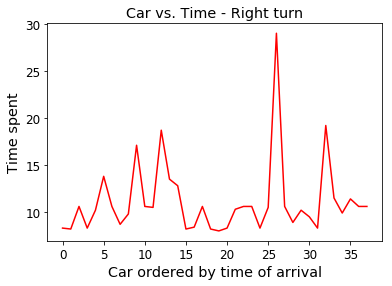

In [18]:
singleSimulation(lr, 'Right turn') 

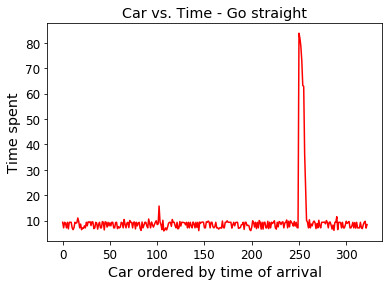

In [19]:
singleSimulation(ls, 'Go straight') 

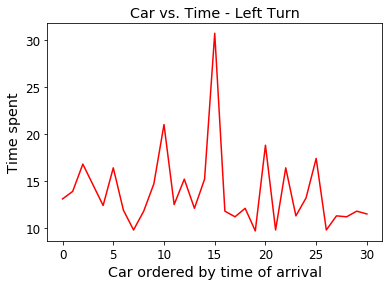

In [20]:
singleSimulation(ll, 'Left Turn') 

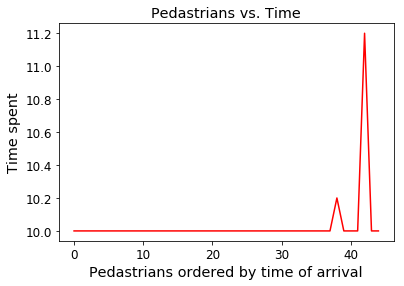

In [21]:
singleSimulation(pt, ped = True)

## 6. Preprocessing 

As shown above, a small portion of the cars were forced to spend significantly longer time than most other cars. We would therefore disregard outliers, which are defined to be cars which spend more than two standard deviations above the average time spent (or two standard deviations below the average, even though it is unlikely). 

We will keep track of the percentage of cars that are disregarded due to this preprocessing, mininimum, maximum, average and standard deviation time spent in each direction. 

In [22]:
def process_list(l): 
    initial = len(l) 
    if initial == 0: 
        return [-1, -1, -1, -1, -1] 
    outliers = 0 
    m = np.mean(l) 
    s = np.std(l) 
    for i in range(initial - 1, -1, -1): 
        if l[i] > m + 2 * s or l[i] < m - 2 * s or l[i] > 60:
            outliers += 1 
            l.pop(i) 
    return [float(outliers) / float(initial), min(l), max(l), np.mean(l), np.std(l)] 

In [23]:
def process_ped(l): 
    return [1, min(l), max(l), np.mean(l), np.std(l)] 

## 7. Simlation 

The following code simulates each combination 100 times, and takes their average. The combinations are as follow: 

$$c = \{(p, s) \mid p \in \{0, 0.1, 0.2, ..., 1.0\} \text{ and } s \in \{0, 0.01, 0.02, ..., 0.20\}\}$$ 

The code can take several hours, depending on your machine. 

In [24]:
np.random.seed(2019) 
outliers = [np.zeros([11, 21]), np.zeros([11, 21]), np.zeros([11, 21]), np.zeros([11, 21])] 
mins = [np.zeros([11, 21]), np.zeros([11, 21]), np.zeros([11, 21]), np.zeros([11, 21])] 
maxs = [np.zeros([11, 21]), np.zeros([11, 21]), np.zeros([11, 21]), np.zeros([11, 21])] 
means = [np.zeros([11, 21]), np.zeros([11, 21]), np.zeros([11, 21]), np.zeros([11, 21])] 
stds = [np.zeros([11, 21]), np.zeros([11, 21]), np.zeros([11, 21]), np.zeros([11, 21])] 
sums = [outliers, mins, maxs, means, stds] 

for a in range(11): 
    for b in range(21): 
        results = [[[], [], [], [], []], [[], [], [], [], []], [[], [], [], [], []], [[], [], [], [], []]] 
        for c in range(100): 
            queues = [[], [], [], []] 
            ped_queues = [[], []] # east and west 
            start, end_straight, end_left, end_right = {}, {}, {}, {} 
            ped_start, ped_end, ped_index = {}, {}, 0 
            time = 0 
            index = 0 
            duration = 1200 
            percentage = a * 0.1 # percentage of auto driving 
            std = b * 0.01 
            car = Car(index, 0, 1) 
            southWait, northWait = [], [] 
            turn = 0.15 
            carDensity = 6 # cars per minute 
            pedDensity = 1.2 # pedestrian crossing per minute 
            eastPed, westPed, eastSignal, westSignal = [-1], [-1], [-1], [-1] 
            while True: 
                for q in queues: 
                    addCar(q, start, time) 
                move1(queues[0], queues[2], queues[3], southWait, westPed) 
                move1(queues[2], queues[0], queues[1], northWait, eastPed) 
                move2(queues[1], eastPed, end_right, time, eastSignal) 
                move2(queues[3], westPed, end_right, time, westSignal) 
                for q in queues: 
                    pop_last(q, end_straight, time) 
                releaseWait(southWait, queues[2], queues[3], end_left, time, westPed, westSignal) 
                releaseWait(northWait, queues[0], queues[1], end_left, time, eastPed, eastSignal) 
                for q in ped_queues: 
                    ped1(q, ped_start, time) 
                ped2(ped_queues[0], eastSignal, eastPed, time) 
                ped2(ped_queues[1], westSignal, westPed, time) 
                manage(eastPed, westPed, eastSignal, westSignal, time) 
                time += dt 
                if time >= duration: 
                    break 
            lr = [end_right[i] - start[i] for i in end_right.keys()]
            ls = [end_straight[i] - start[i] for i in end_straight.keys()]
            ll = [end_left[i] - start[i] for i in end_left.keys()] 
            pt = [ped_end[i] - ped_start[i] for i in ped_end.keys()] 
            results_processed = [process_list(lr) , process_list(ls) , process_list(ll), process_ped(pt)] 
            for m in range(4): 
                for n in range(5): 
                    if results_processed[m][n] != -1: 
                        results[m][n].append(results_processed[m][n]) 
        for m in range(5): 
            for n in range(4): 
                sums[m][n][a, b] = avg(results[n][m]) 
    print('Finished %.1f%%' % (float(a + 1) * 100 / 11)) 

Finished 9.1%
Finished 18.2%
Finished 27.3%
Finished 36.4%
Finished 45.5%
Finished 54.5%
Finished 63.6%
Finished 72.7%
Finished 81.8%
Finished 90.9%
Finished 100.0%


## 8. Save as CSV files 
All results would be saved as CSV files to the `csv` file. 

In [25]:
filenames1 = ['outlier', 'min', 'max', 'mean', 'std'] 
filenames2 = ['left', 'straight', 'right', 'pedastrians'] 

for save_a in range(len(filenames1)): 
    for save_b in range(len(filenames2)): 
        filename = 'csv\\' + filenames1[save_a] + '_' + filenames2[save_b] + '.csv' 
        np.savetxt(filename, sums[save_a][save_b], delimiter = ",") 

## 9. Plottings
`plot` function to plot all the following graphs. 

`plotting` function displays the results in the notebook, and the two `save_plot` functions saves the images to `graphs\percentage` and `graphs\standardDeviation`. 

In [26]:
colors = ['#FF0000', '#FF4000', '#FF8000', '#FFBF00', '#FFFF00', '#BFFF00', '#80FF00', 
          '#40FF00', '#00FF00', '#00FF40', '#00FF80', '#00FFBF', '#00FFFF', '#00BFFF', 
          '#0080FF', '#0040FF', '#0000FF', '#4000FF', '#8000FF', '#BF00FF', '#FF00FF'] 
legends1 = ["%d%%" % (i * 100) for i in np.linspace(0, 1, 11)]
legends2 = ["%.2f" % i for i in np.linspace(0, 0.2, 21)] 

def plotting(data, title, direction, legend_loc1 = 'upper left', legend_loc2 = 'upper right', 
             l_size1 = 12, l_size = 12, outlier = False): 
    xticks1 = ticker.MaxNLocator(12) 
    xticks2 = ticker.MaxNLocator(12) 
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 8)) 
    fig.suptitle(title + ' - ' + direction, fontsize = 18) 
    for i in range(len(data)): 
        ax1.plot(np.linspace(0, 0.2, 21), data[i], label = legends1[i], color = colors[i * 2])
    ax1.legend(loc = legend_loc1, ncol = 4, prop = {'size' : l_size1})
    d_copy = np.transpose(data) 
    for i in range(len(d_copy)): 
        ax2.plot(np.linspace(0, 1, 11), d_copy[i], label = legends2[i], color = colors[i])
    ax2.legend(loc = legend_loc2, ncol = 3, prop = {'size' : l_size})
    ax1.xaxis.set_major_locator(xticks1) 
    ax2.xaxis.set_major_locator(xticks2) 
    ax1.set_title('Standard Deviation of Manual Drivers vs. ' + title, size = 15) 
    ax2.set_title('Autonomous Vehicle Percentage vs. ' + title, size = 15)
    xvals = ax2.get_xticks() 
    ax2.set_xticklabels(['{:,.0%}'.format(x) for x in xvals]) 
    ax1.set_xlabel('Standard Deviation') 
    ax1.set_ylabel(title) 
    ax2.set_xlabel('Autonomous Vehicle Percentage') 
    ax2.set_ylabel(title) 
    if outlier: 
        vals = ax1.get_yticks() 
        ax1.set_yticklabels(['{:,.1%}'.format(x) for x in vals]) 
        ax2.set_yticklabels(['{:,.1%}'.format(x) for x in vals]) 
    plt.show() 

In [27]:
def save_plot(data, title, direction, legend_loc2 = 'upper left', l_size = 6, outlier = False): 
    fig = plt.figure() 
    ax = fig.add_subplot(1, 1, 1) 
    xticks = ticker.MaxNLocator(12) 
    for i in range(len(data)): 
        ax.plot(np.linspace(0, 0.2, 21), data[i], color = colors[i * 2], label = legends1[i]) 
    filename = title.lower() + ' ' + direction.lower() + '.png' 
    ax.legend(loc = legend_loc2, ncol = 4, prop = {'size' : l_size})
    ax.xaxis.set_major_locator(xticks) 
    xvals = ax.get_xticks() 
    if outlier: 
        vals = ax.get_yticks() 
        ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals]) 
    fig.savefig('graphs\\standardDeviation\\' + filename, dpi = 200) 
    plt.close(fig) 
    
def save_plot2(data, title, direction, legend_loc2 = 'upper right', l_size = 6, outlier = False): 
    fig = plt.figure() 
    ax = fig.add_subplot(1, 1, 1) 
    xticks = ticker.MaxNLocator(12) 
    d_copy = np.transpose(data) 
    for i in range(len(d_copy)): 
        ax.plot(np.linspace(0, 1, 11), d_copy[i], label = legends2[i], color = colors[i])
    filename = title.lower() + ' ' + direction.lower() + '.png' 
    ax.legend(loc = legend_loc2, ncol = 3, prop = {'size' : l_size})
    ax.xaxis.set_major_locator(xticks) 
    xvals = ax.get_xticks() 
    if outlier: 
        vals = ax.get_yticks() 
        ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals]) 
    ax.set_xticklabels(['{:,.0%}'.format(x) for x in xvals]) 
    fig.savefig('graphs\\percentage\\' + filename, dpi = 200) 
    plt.close(fig) 
    
def plot(data, title, direction, legend_loc1 = 'upper left', legend_loc2 = 'upper right', l_size1 = 12, l_size = 12, 
         s_size = 6, outlier = False): 
    plotting(data, title, direction, legend_loc1 = legend_loc1, legend_loc2 = legend_loc2, 
             l_size1 = l_size1, l_size = l_size, outlier = outlier) 
    save_plot(data, title, direction, legend_loc2 = legend_loc1, l_size = s_size, outlier = outlier) 
    save_plot2(data, title, direction, legend_loc2 = legend_loc2, l_size = s_size, outlier = outlier) 

## 10. Results 

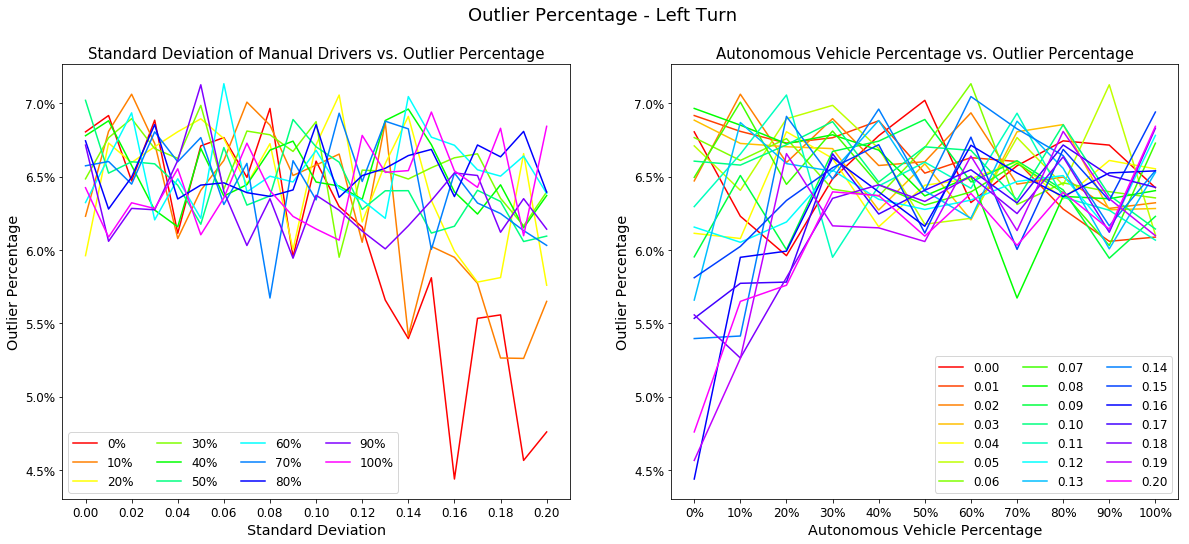

In [28]:
plot(sums[0][0], 'Outlier Percentage', 'Left Turn', legend_loc1 = 'lower left', legend_loc2 = 'lower right', outlier = True) 

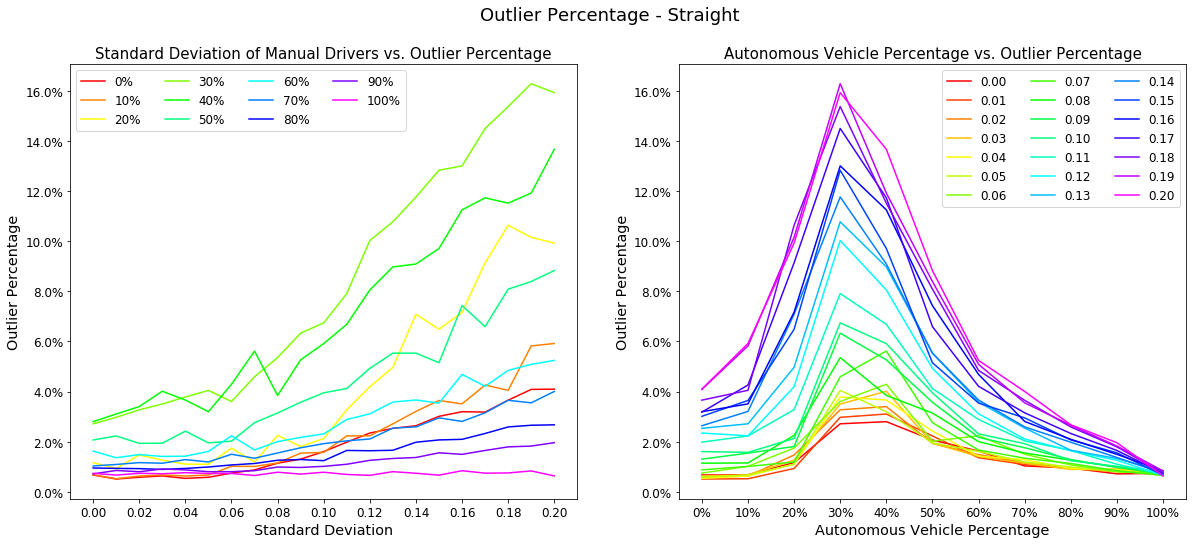

In [29]:
plot(sums[0][1], 'Outlier Percentage', 'Straight', outlier = True)

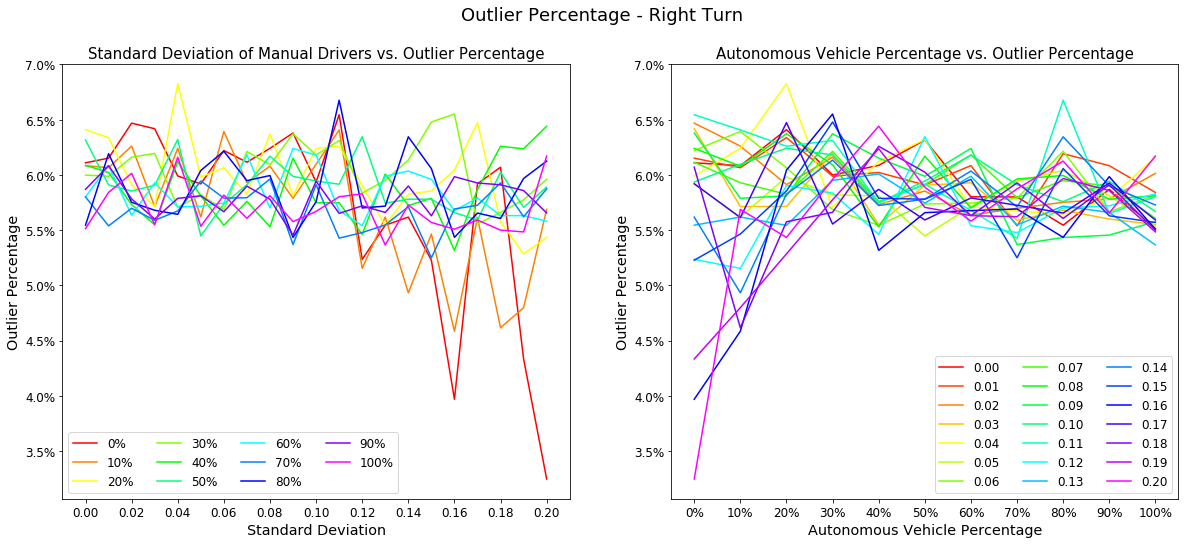

In [30]:
plot(sums[0][2], 'Outlier Percentage', 'Right Turn', legend_loc1 = 'lower left', legend_loc2 = 'lower right', outlier = True)

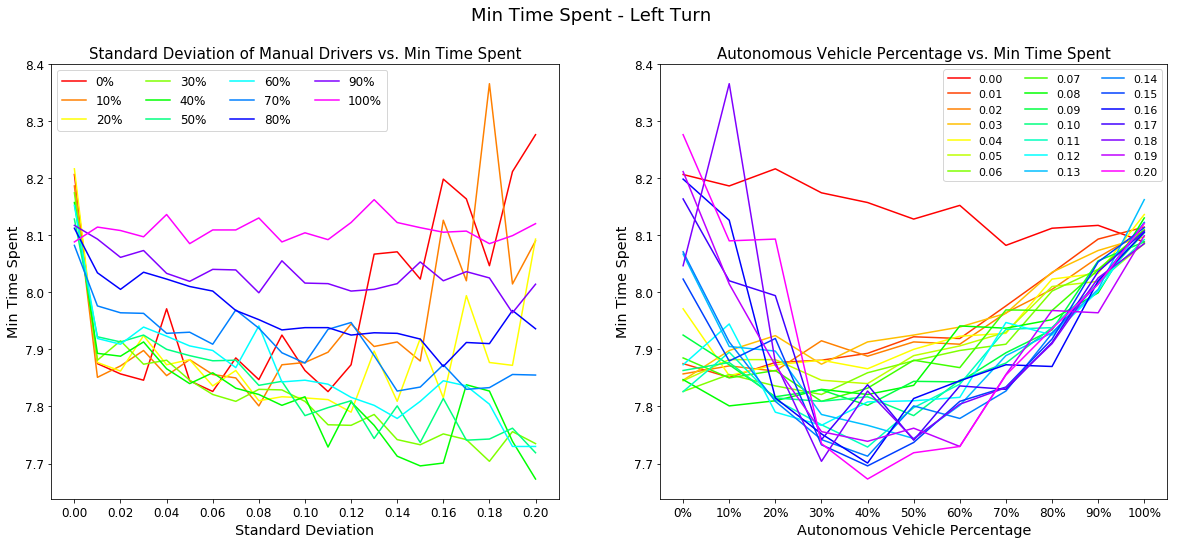

In [31]:
plot(sums[1][0], 'Min Time Spent', 'Left Turn', l_size = 11)

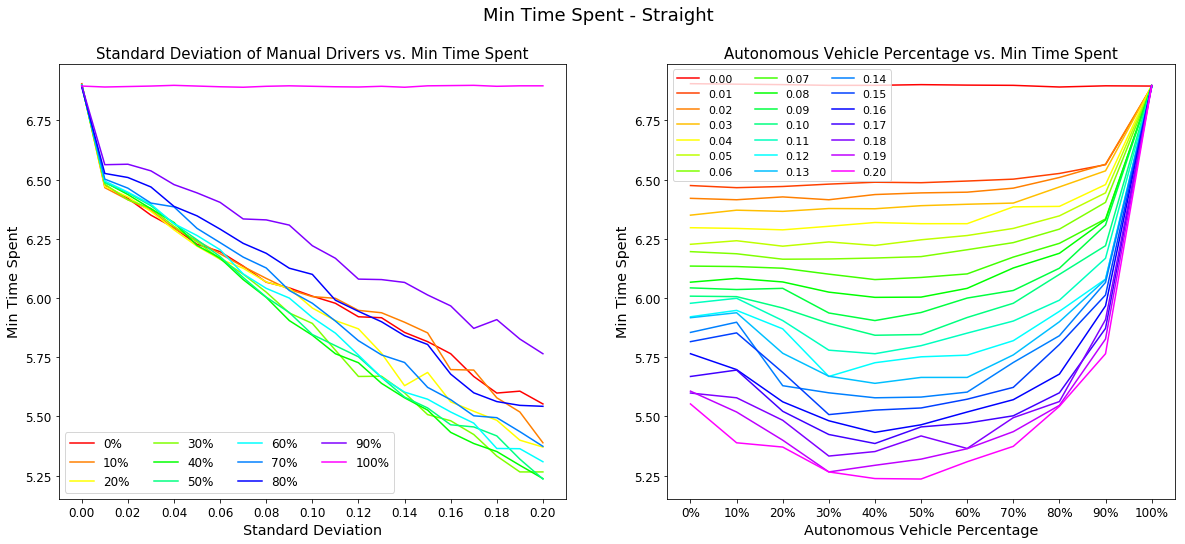

In [32]:
plot(sums[1][1], 'Min Time Spent', 'Straight', legend_loc1 = 'lower left', legend_loc2 = 'upper left', l_size = 11)

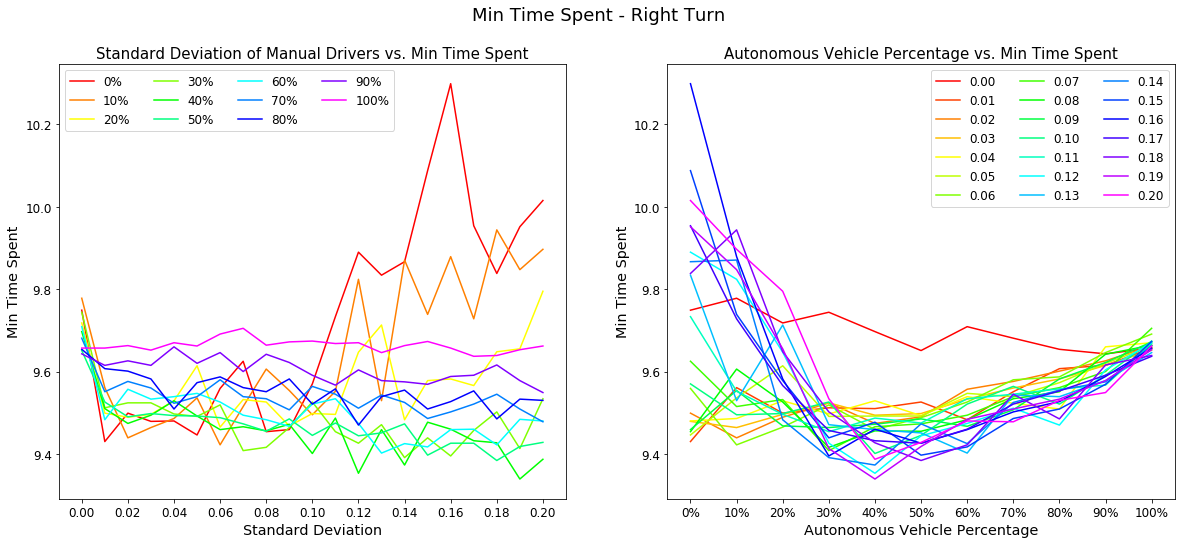

In [33]:
plot(sums[1][2], 'Min Time Spent', 'Right Turn')

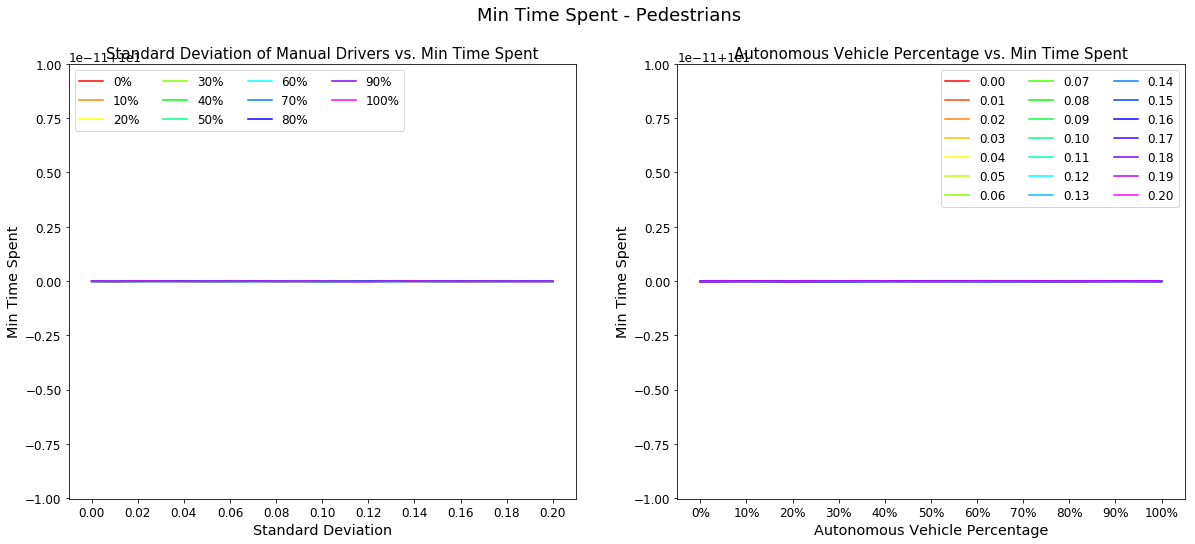

In [34]:
plot(sums[1][3], 'Min Time Spent', 'Pedestrians')

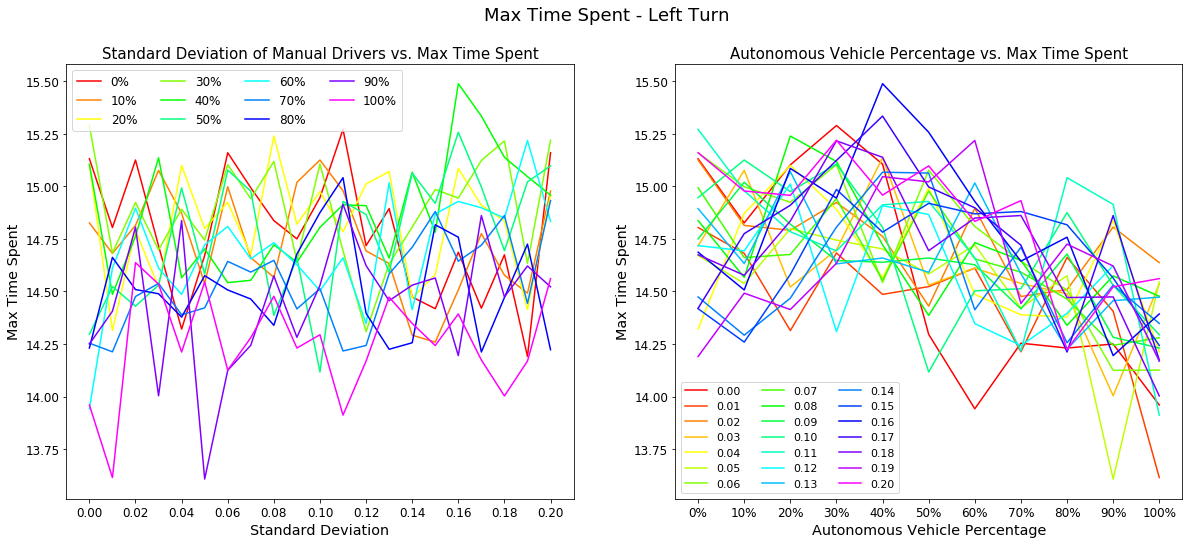

In [35]:
plot(sums[2][0], 'Max Time Spent', 'Left Turn', legend_loc2 = 'lower left', l_size = 11)

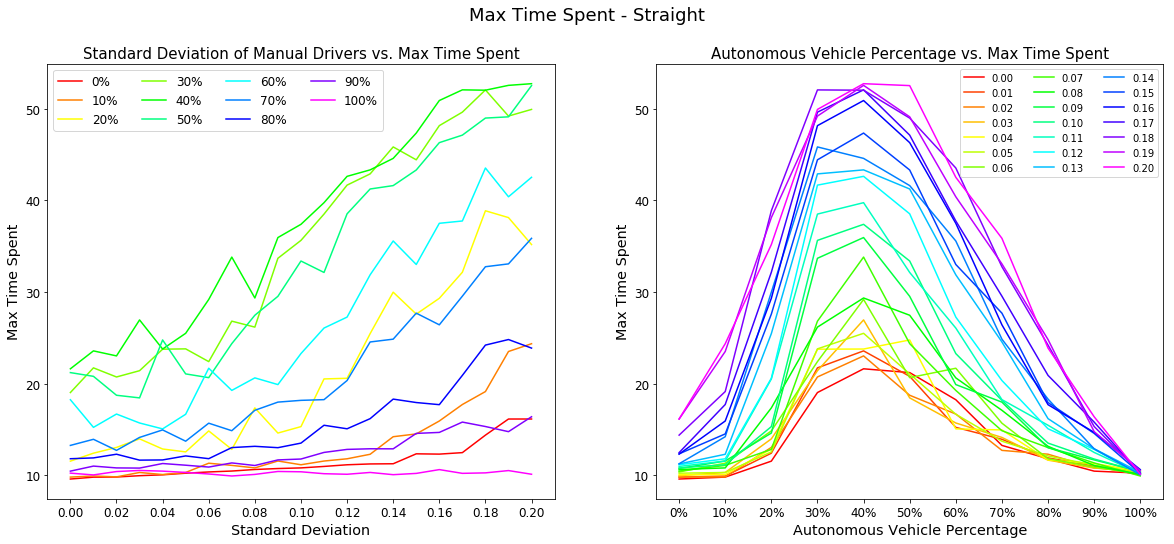

In [36]:
plot(sums[2][1], 'Max Time Spent', 'Straight', l_size = 10)

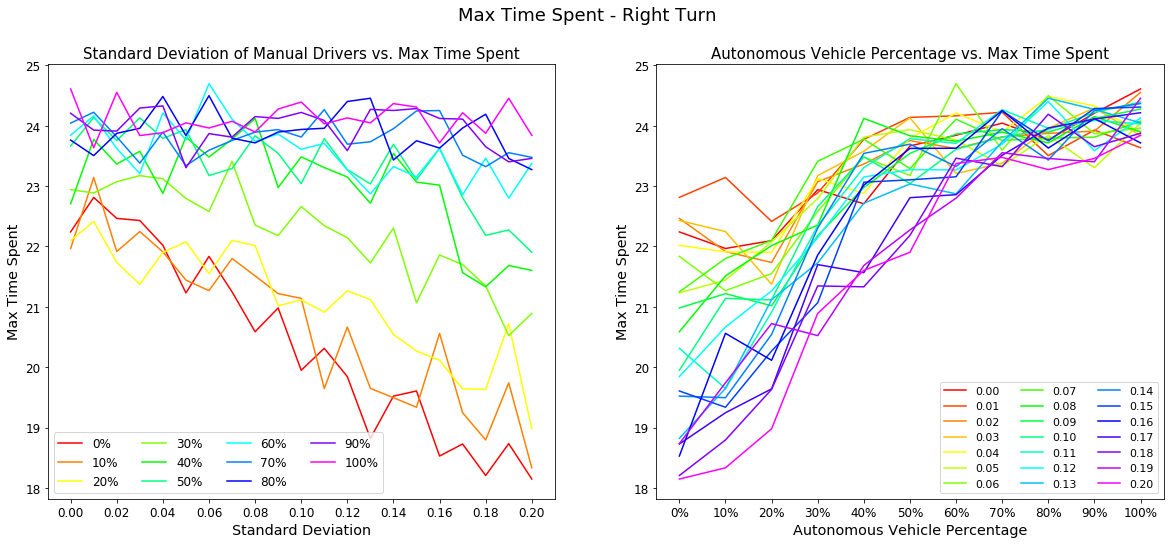

In [37]:
plot(sums[2][2], 'Max Time Spent', 'Right Turn', legend_loc1 = 'lower left', legend_loc2 = 'lower right', l_size = 11)

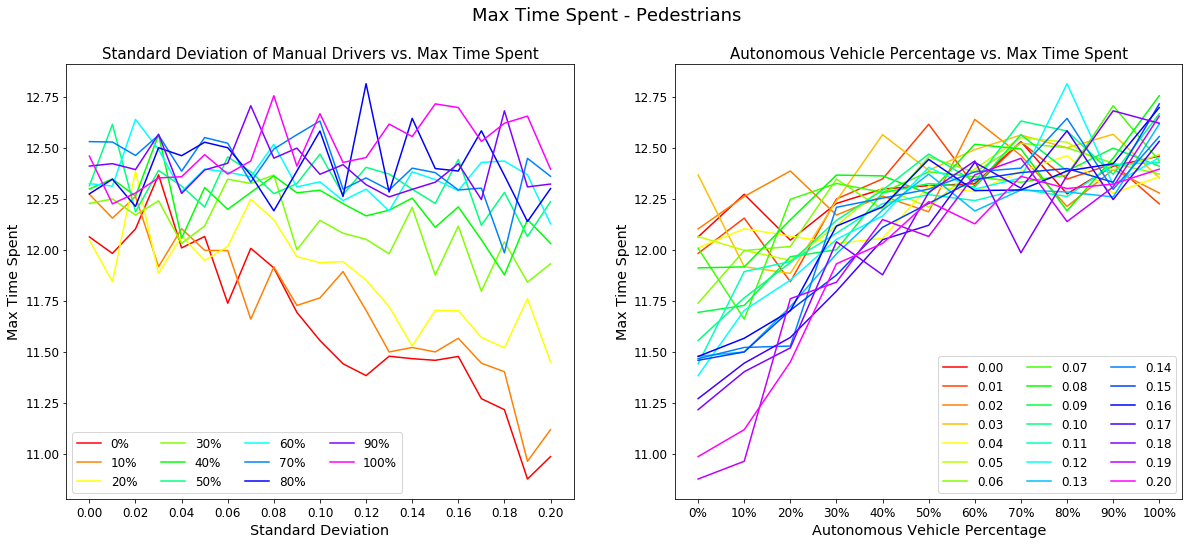

In [38]:
plot(sums[2][3], 'Max Time Spent', 'Pedestrians', legend_loc1 = 'lower left', legend_loc2 = 'lower right')

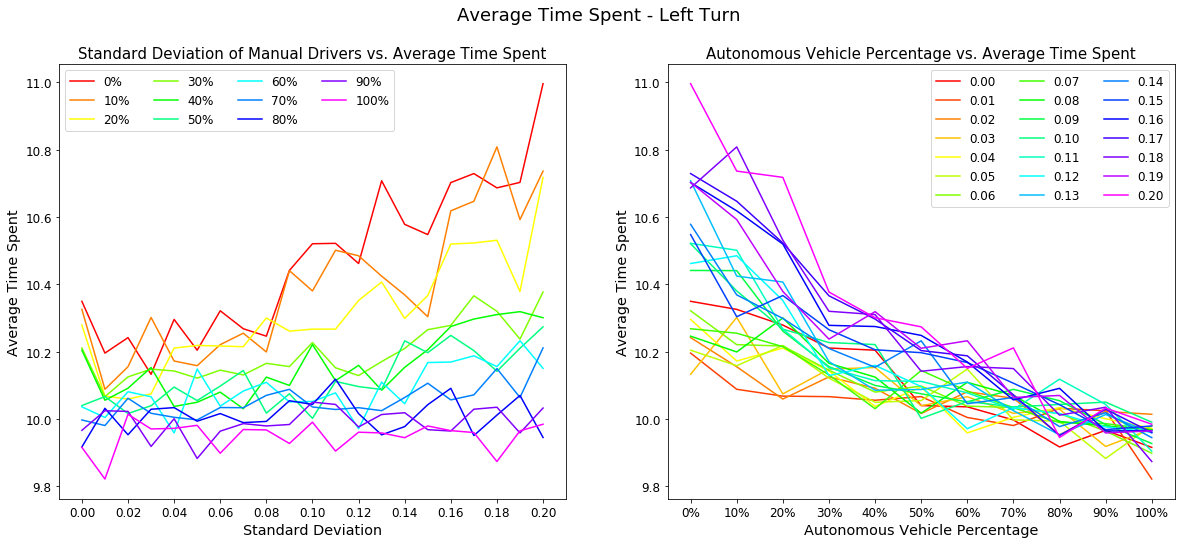

In [39]:
plot(sums[3][0], 'Average Time Spent', 'Left Turn')

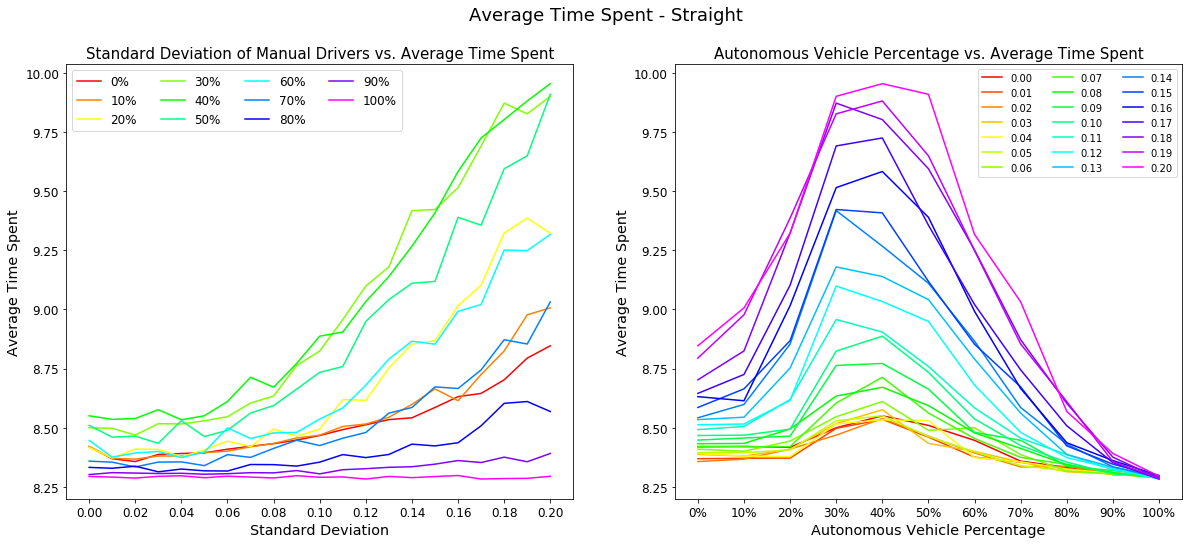

In [40]:
plot(sums[3][1], 'Average Time Spent', 'Straight', l_size = 10)

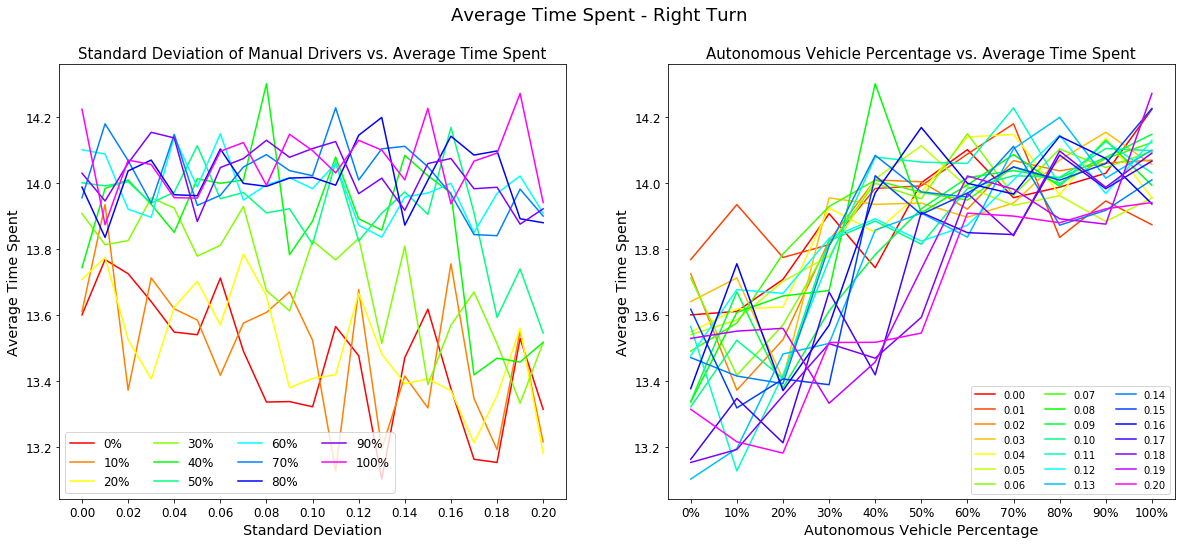

In [41]:
plot(sums[3][2], 'Average Time Spent', 'Right Turn', l_size = 10, legend_loc1 = 'lower left', legend_loc2 = 'lower right') 

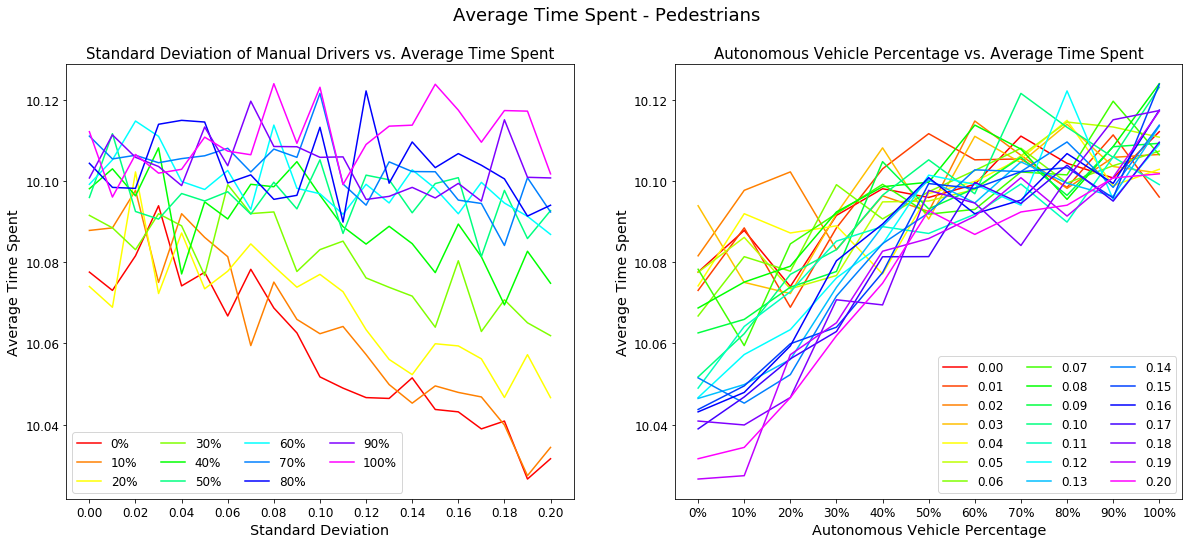

In [42]:
plot(sums[3][3], 'Average Time Spent', 'Pedestrians', legend_loc1 = 'lower left', legend_loc2 = 'lower right')

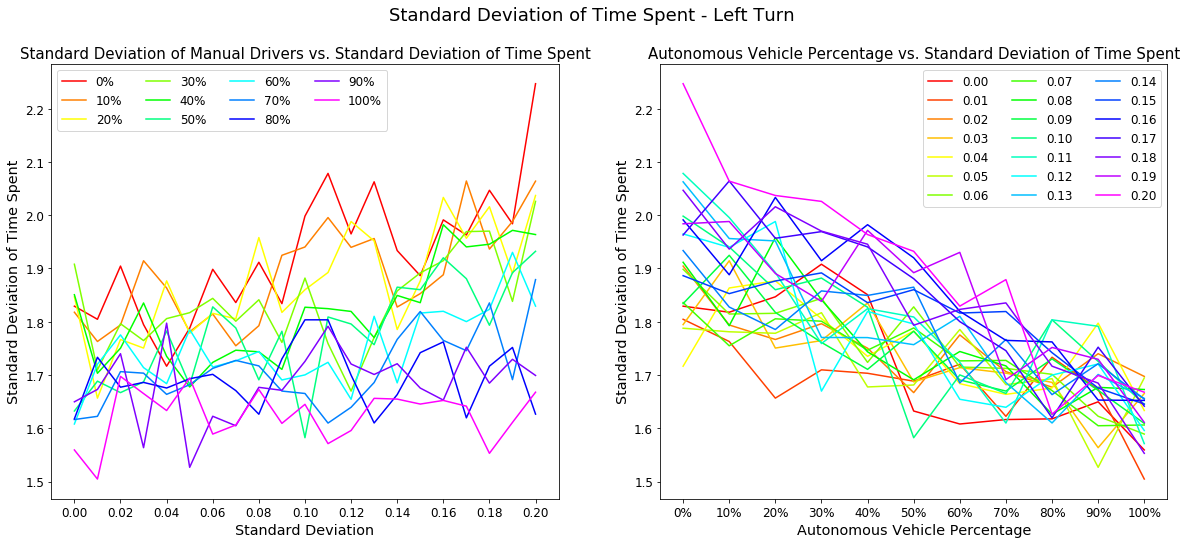

In [43]:
plot(sums[4][0], 'Standard Deviation of Time Spent', 'Left Turn')

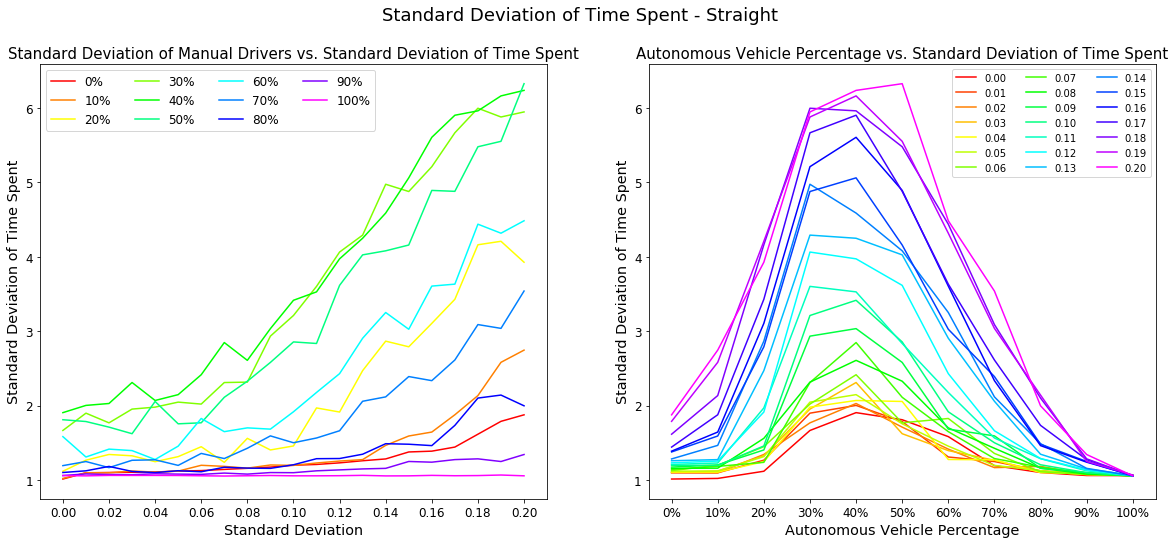

In [44]:
plot(sums[4][1], 'Standard Deviation of Time Spent', 'Straight', l_size = 10)

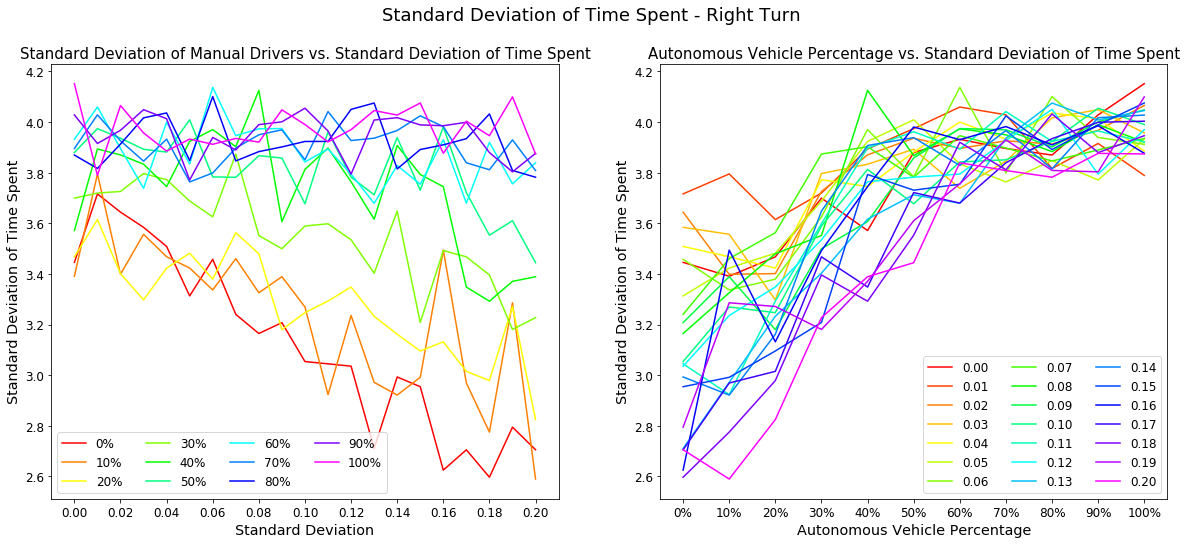

In [45]:
plot(sums[4][2], 'Standard Deviation of Time Spent', 'Right Turn', legend_loc1 = 'lower left', legend_loc2 = 'lower right')

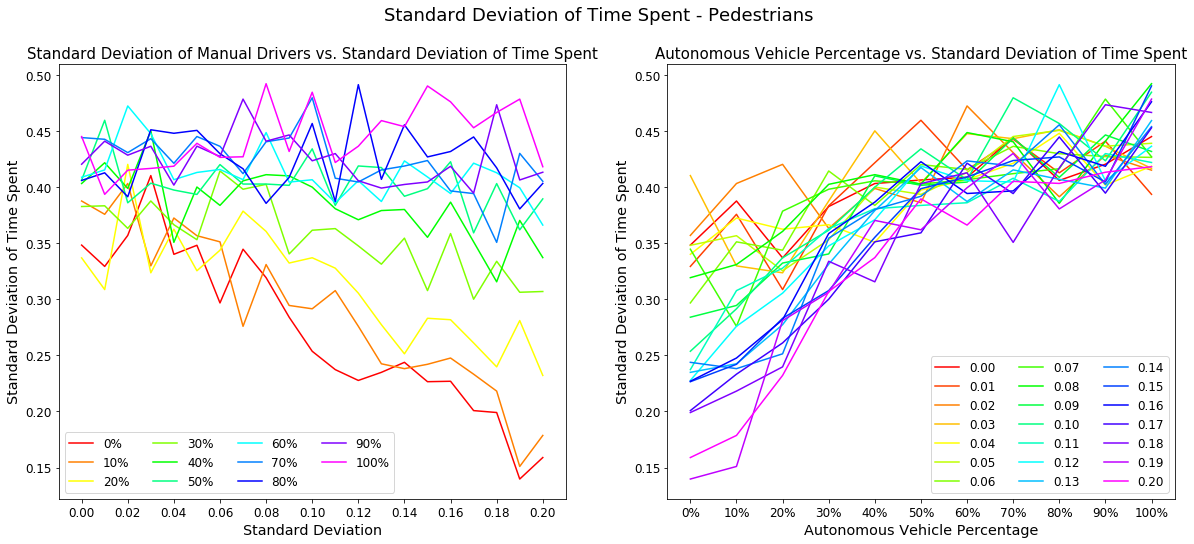

In [46]:
plot(sums[4][3], 'Standard Deviation of Time Spent', 'Pedestrians', legend_loc1 = 'lower left', legend_loc2 = 'lower right')